In [8]:
%load_ext autoreload
%autoreload 2

import torch
import transformers
import pandas as pd 
import text_extensions_for_pandas as tp
from tqdm import tqdm
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader

!ls

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
__pycache__            hwaj_notebook.ipynb    results
baselines              ingest_data_test.ipynb saved_models
data_logical_fallacy   model.py               trainingOutput
data_proppy            new_model.py           use_tep.ipynb
dataset.py             pytorch_train.py
dataset_bert.py        readme.md


In [11]:
colnames = ['text','event_location','average_tone','article_date','article_ID','article_URL_1','MBFC_factuality_label_1','article_URL','MBFC_factuality_label','URL_to_MBFC_page','source_name','MBFC_notes_about_source','MBFC_bias_label','source_URL','propaganda_label']
proppy_dev = pd.read_csv("data_proppy/proppy_1.0.dev.tsv",sep='\t',names=colnames)[["text",'average_tone','source_name','propaganda_label']]
proppy_dev.head()

,text,average_tone,source_name,propaganda_label
0,Convened to examine the causes of civil unrest...,-4.593640,The Hartford Courant,-1
1,Discriminating against someone on the basis of...,-1.566952,The Hartford Courant,-1
2,"Bill Cosby's 44-year-old daughter, Ensa Cosby,...",-6.150660,The Hartford Courant,-1
3,"The fast-moving, powerful theatrical locomotiv...",1.524390,The Hartford Courant,-1
4,It's Friday. It's National Pizza Day. Grab lif...,1.197605,The Hartford Courant,-1


In [ ]:
bert_model_name = "bert-base-uncased"

tokenizer = transformers.BertTokenizerFast.from_pretrained(bert_model_name, 
                                                           add_special_tokens=True)
bert = transformers.BertModel.from_pretrained(bert_model_name)




Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
feats = np.zeros([len(proppy_dev),768])

for i,row in tqdm(proppy_dev.iterrows()): 
    toks = tp.io.bert.make_bert_tokens(proppy_dev.text[i],tokenizer)
    emb_df = tp.io.bert.add_embeddings(toks, bert)
    feats[i,:] = emb_df.embedding.to_numpy().mean(axis=0)
    
    
    

5125it [3:37:40,  2.55s/it]


In [40]:
len(proppy_dev)

5125

In [41]:
feats

array([[-0.07519729,  0.1750659 ,  0.22689338, ..., -0.06930672,
         0.06440458, -0.00516594],
       [-0.10818958,  0.09823903,  0.13773319, ...,  0.04717225,
        -0.00811862,  0.14017554],
       [-0.13764539,  0.02021009,  0.24139456, ...,  0.03524834,
         0.21321787, -0.08245312],
       ...,
       [-0.1374764 ,  0.10403664,  0.13267258, ..., -0.02726575,
         0.19213852,  0.14666592],
       [ 0.05461893,  0.3660191 ,  0.19056308, ..., -0.06918009,
         0.20644763,  0.0774904 ],
       [ 0.05102529,  0.07965963,  0.25242335, ..., -0.09123608,
         0.2235851 ,  0.09679378]])

In [42]:
feats_pt = torch.from_numpy(feats)


In [44]:
torch.save(feats_pt,"results/proppy_dev.pt")

In [294]:
proppy_train = pd.read_csv("data_proppy/proppy_1.0.train.tsv",sep='\t',names=colnames)[["text",'average_tone','source_name','propaganda_label']]
proppy_train.head()

,text,average_tone,source_name,propaganda_label
0,"Et tu, Rhody? A recent editorial in the Provi...",-3.181818,The Hartford Courant,-1
1,A recent post in The Farmington Mirror — our t...,-0.424328,The Hartford Courant,-1
2,"President Donald Trump, as he often does while...",-2.469136,The Hartford Courant,-1
3,"February is Black History Month, and nothing l...",-0.894632,The Hartford Courant,-1
4,"The snow was so heavy, whipped up by gusting w...",-4.800000,The Hartford Courant,-1


In [305]:
ratios = proppy_train[["text","propaganda_label"]].rename(columns={'text':'count'}).groupby("propaganda_label").count()

ratios["perc"] = ratios['count']/ ratios['count'].to_numpy().sum()
ratios

,count,perc
propaganda_label,,
-1,31965,0.888262
1,4021,0.111738


In [47]:
feats_train = np.zeros([len(proppy_train),768])

for i,row in tqdm(proppy_train.iterrows()): 
    toks = tp.io.bert.make_bert_tokens(proppy_train.text[i],tokenizer)
    emb_df = tp.io.bert.add_embeddings(toks, bert)
    feats_train[i,:] = emb_df.embedding.to_numpy().mean(axis=0)

35986it [25:19:36,  2.53s/it]


In [48]:
train_pt = torch.from_numpy(feats_train)
torch.save(train_pt,"results/proppy_train.pt")

In [49]:
proppy_test = pd.read_csv("data_proppy/proppy_1.0.test.tsv",sep='\t',names=colnames)[["text",'average_tone','source_name','propaganda_label']]
proppy_test.head()

,text,average_tone,source_name,propaganda_label
0,Eat in Connecticut teamed up with End Hunger C...,0.781250,The Hartford Courant,-1
1,Owners of an old Pennsylvania power plant that...,-1.615799,The Hartford Courant,-1
2,The majority owner of President Donald Trump's...,-4.177546,The Hartford Courant,-1
3,Connecticut’s most likely option for using tol...,-7.200811,The Hartford Courant,-1
4,Escaped prisoner Jerry Mercado is back in Conn...,-6.534091,The Hartford Courant,-1


In [50]:
feats_test = np.zeros([len(proppy_test),768])

for i,row in tqdm(proppy_test.iterrows()): 
    toks = tp.io.bert.make_bert_tokens(proppy_test.text[i],tokenizer)
    emb_df = tp.io.bert.add_embeddings(toks, bert)
    feats_test[i,:] = emb_df.embedding.to_numpy().mean(axis=0)
    

10159it [6:41:51,  2.37s/it]


In [221]:
test_pt = torch.from_numpy(feats_test)
torch.save(test_pt,"results/proppy_test.pt")

In [63]:
# define funct that does ^ 
def make_emb_vecs(df, tokenizer, bert, out_file_name = None, text_col = "text"): 
    feats = np.zeros([len(df),768])
    for i in tqdm(range(len(df))): 
        toks = tp.io.bert.make_bert_tokens(df.loc[i,text_col],tokenizer)
        emb_df = tp.io.bert.add_embeddings(toks,bert) 
        feats[i,:] = emb_df.embedding.to_numpy().mean(axis=0)
    if out_file_name is not None: 
        torch.save(torch.from_numpy(feats),out_file_name)
    return feats 


In [65]:
train_fal_df = pd.read_csv("data_logical_fallacy/climate_train.csv")
test_fal_df  = pd.read_csv("data_logical_fallacy/climate_test.csv")
dev_fal_df   = pd.read_csv("data_logical_fallacy/climate_dev.csv")
dev_fal_df

,Unnamed: 0,original_url,source_article,logical_fallacies
0,52,https://www.thesun.co.uk/tech/11044576/new-isl...,Rising temperatures in Antarctica over the pas...,false causality
1,1226,https://www.forbes.com/sites/robertbradley/201...,Green activists are at war with the greatest A...,intentional
2,413,https://www.bostonglobe.com/opinion/columns/20...,The list of variables that shape climate inclu...,fallacy of extension
3,1112,http://www.breitbart.com/big-government/2017/0...,What all these papers argue in their different...,intentional
4,559,https://www.forbes.com/sites/jamestaylor/2015/...,The Facts\n\nGlobal warming alarmists ’ prefer...,fallacy of logic
...,...,...,...,...
195,1341,https://www.telegraph.co.uk/news/science/11733...,The earth is 15 years from a period of low sol...,intentional
196,1018,https://www.theatlantic.com/health/archive/201...,To understand why the climate impact of beef a...,fallacy of logic
197,375,http://www.cnn.com/2017/05/29/opinions/withdra...,"And as soon as possible , President Trump shou...",fallacy of extension
198,1165,https://www.telegraph.co.uk/news/2017/05/06/an...,"Inevitably , when even satellite temperatures ...",intentional


In [12]:
fal_train_feats = make_emb_vecs(train_fal_df,tokenizer,bert,"results/climate_train.pt",text_col = "source_article")
fal_dev_feats = make_emb_vecs(dev_fal_df,tokenizer,bert,"results/climate_dev.pt",text_col = "source_article")
fal_test_feats = make_emb_vecs(test_fal_df,tokenizer,bert,"results/climate_test.pt",text_col = "source_article")

NameError: name 'make_emb_vecs' is not defined

In [13]:
# pre-train on
from dataset_bert import FallacyDatasetEmb
from pathlib import Path
data_train = FallacyDatasetEmb(Path("data_logical_fallacy","climate_train.csv"),
                            Path("results","climate_train.pt"),
                            label_header="logical_fallacies")
data_dev = FallacyDatasetEmb(Path("data_logical_fallacy","climate_dev.csv"),
                            Path("results","climate_dev.pt"),
                            label_header="logical_fallacies")
data_dev = FallacyDatasetEmb(Path("data_logical_fallacy","climate_test.csv"),
                            Path("results","climate_test.pt"),
                            label_header="logical_fallacies")

In [14]:
from torch.utils.data import DataLoader

fal_train_loader = DataLoader(data_train,batch_size=16,shuffle=True)
fal_dev_loader = DataLoader(data_dev,batch_size=16,shuffle=True)

In [15]:
from torch.optim import AdamW
from new_model import FallacyModel
from torch.nn import CrossEntropyLoss
from sklearn.metrics import f1_score, accuracy_score


device = 'cuda' if torch.cuda.is_available() else 'cpu' 

fmodel = FallacyModel(n_hiddens=20).to(device)
optim = AdamW(fmodel.parameters(), lr = 1e-4,weight_decay = 1e-2)
loss_fn = CrossEntropyLoss()

fmodel.train()
train_losses = []
train_accs = []
dev_losses = []
dev_accs = []

for epoch in tqdm(range(200)): 
    preds = []
    labs = []
    losses = [] 
    for batch in fal_train_loader: 
        optim.zero_grad()
        labels = batch['label'].to(device)
        feats = batch['feats'].to(device)

        out = fmodel(feats)
        loss = loss_fn(out,labels)
        loss.backward()
        optim.step()
        preds += torch.argmax(out,dim=1).cpu().tolist() 
        labs += batch['label'].tolist()
        losses.append(float(loss.cpu()))
    train_losses.append(sum(losses)/len(losses))
    train_accs.append(accuracy_score(labs,preds))
    # test model on dev set 
    fmodel.eval()
    dev_los_acc = []
    dev_preds = []
    dev_labels = []
    for batch in fal_dev_loader: 
        labels = batch['label'].to(device)
        feats = batch['feats'].to(device)

        out = fmodel(feats)
        loss = loss_fn(out,labels)
        dev_preds += torch.argmax(out,dim=1).cpu().tolist() 
        dev_labels += batch['label'].tolist()
        dev_los_acc.append(float(loss.cpu()))
    dev_losses.append(sum(dev_los_acc)/len(dev_los_acc))
    dev_accs.append(accuracy_score(dev_labels,dev_preds))
    fmodel.train()
    # print(f'at epoch {epoch}, train L: {train_losses[-1]}, Dev L: {dev_losses[-1]}') 
    



100%|█████████████████████████████████████████| 200/200 [00:13<00:00, 14.63it/s]


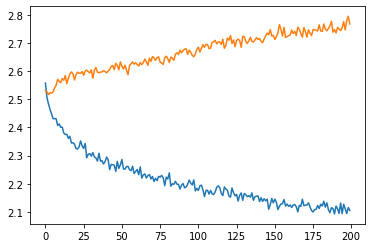

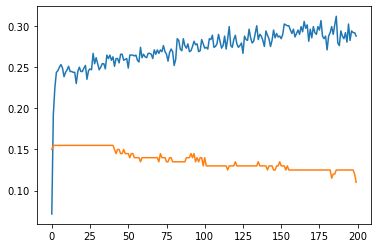

In [16]:
from matplotlib import pyplot as plt 

plt.plot(list(range(len(train_losses))),train_losses)
plt.plot(list(range(len(train_losses))),dev_losses)

plt.figure()
plt.plot(list(range(len(train_losses))),train_accs)
plt.plot(list(range(len(train_losses))),dev_accs)


In [17]:
len(dev_fal_df.logical_fallacies.unique())

NameError: name 'dev_fal_df' is not defined

In [177]:
float(loss.cpu())

0.5724276900291443

In [18]:
# create datasets
from dataset_bert import ProppyDatasetEmb
proppy_train_set = ProppyDatasetEmb(filepath=Path("data_proppy/proppy_1.0.train.tsv"),embspath="results/proppy_train.pt")
proppy_dev_set = ProppyDatasetEmb(filepath=Path("data_proppy/proppy_1.0.dev.tsv"),embspath="results/proppy_dev.pt")
proppy_test_set = ProppyDatasetEmb(filepath=Path("data_proppy/proppy_1.0.test.tsv"),embspath="results/proppy_test.pt")



0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [19]:
prop_train_loader = DataLoader(proppy_train_set,batch_size=16,shuffle=True)
prop_dev_loader = DataLoader(proppy_dev_set,batch_size=16,shuffle=True)


In [20]:
# train model from  past thing 


In [87]:
from torch.optim import AdamW
from new_model import FallacyModel
from torch.nn import BCELoss
from sklearn.metrics import f1_score, accuracy_score
from new_model import ProppyModel


pmodel = ProppyModel(from_model =fmodel,dropout_p=0.3)
# pmodel = ProppyModel(n_hiddens=200)


train_losses = []
train_accs = []
dev_losses = []
dev_accs = []
pos_portion = []

In [49]:
weight_prop = .8
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
optim = AdamW(pmodel.parameters(), lr = 3e-5,weight_decay = 1e-8)
loss_fn = CrossEntropyLoss(weight=torch.Tensor([1-weight_prop,weight_prop]))
dev_loss_fn = CrossEntropyLoss()
pmodel.train()



for epoch in tqdm(range(200)): 
    preds = []
    labs = []
    losses = [] 
    for batch in prop_train_loader: 
        optim.zero_grad()
        labels = batch['label'].to(device)
        feats = batch['feats'].to(device)
        

        out = pmodel(feats)
        loss = loss_fn(out,labels)
        loss.backward()
        optim.step()
        preds += torch.argmax(out,dim=1).cpu().tolist() 
        labs += batch['label'].tolist()
        losses.append(float(loss.cpu()))
    train_losses.append(sum(losses)/len(losses))
    train_accs.append(accuracy_score(labs,preds))
    # test model on dev set 
    pmodel.eval()
    dev_los_acc = []
    dev_preds = []
    dev_labels = []
    for batch in prop_dev_loader: 
        labels = batch['label'].to(device)
        feats = batch['feats'].to(device)

        out = pmodel(feats)
        loss = loss_fn(out,labels)
        dev_preds += torch.argmax(out,dim=1).cpu().tolist() 
        dev_labels += batch['label'].tolist()
        dev_los_acc.append(float(loss.cpu()))
    dev_losses.append(sum(dev_los_acc)/len(dev_los_acc))
    dev_accs.append(accuracy_score(dev_labels,dev_preds))
    pos_portion.append(sum(dev_preds)/len(dev_preds))
    pmodel.train()
    # print(f'at epoch {epoch}, train L: {train_losses[-1]}, Dev L: {dev_losses[-1]}') 
    

100%|█████████████████████████████████████████| 200/200 [15:23<00:00,  4.62s/it]


[autoreload of dataset_bert failed: Traceback (most recent call last):
  File "/Users/zachary/opt/anaconda3/envs/eecs_nlp/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/zachary/opt/anaconda3/envs/eecs_nlp/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/zachary/opt/anaconda3/envs/eecs_nlp/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/zachary/opt/anaconda3/envs/eecs_nlp/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bo

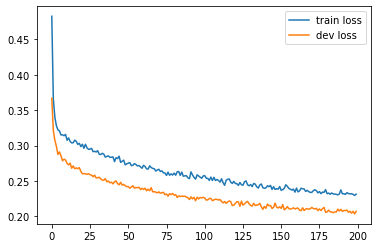

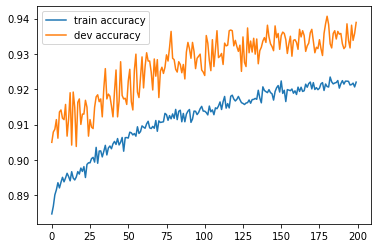

In [50]:
from matplotlib import pyplot as plt 

plt.plot(list(range(len(train_losses))),train_losses)
plt.plot(list(range(len(train_losses))),dev_losses)
plt.legend(['train loss','dev loss'])

plt.figure()
plt.plot(list(range(len(train_losses))),train_accs)
plt.plot(list(range(len(train_losses))),dev_accs)
plt.legend(['train accuracy','dev accuracy'])


In [47]:
dev_accs[-1]

0.9278048780487805

In [38]:
torch.save(pmodel,"results/basic_model_epoch_lorg_500_ac.920.pt")

# Test models on balanced dataset 

In [60]:
# balanced datasets  
from sklearn.metrics import precision_recall_fscore_support
balanced_ds = {}
balanced_ds['train'] = ProppyDatasetEmb(filepath=Path("data_proppy/proppy_1.0.train.tsv")
                                        ,embspath="results/proppy_train.pt",balance=True)
balanced_ds['dev'] = ProppyDatasetEmb(filepath=Path("data_proppy/proppy_1.0.dev.tsv")
                                         ,embspath="results/proppy_dev.pt",balance=True)
balanced_ds['test'] = ProppyDatasetEmb(filepath=Path("data_proppy/proppy_1.0.test.tsv")
                                        ,embspath="results/proppy_test.pt",balance=True)    

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [80]:
from sklearn.metrics import confusion_matrix


def get_stats(model,datasets):
    outputs = {}
    for name,ds in datasets.items(): 
        loader = DataLoader(ds,batch_size=32) 
        model.eval()
        all_labs = []
        all_preds= [] 
        for batch in loader: 
            labels = batch['label']
            feats = batch['feats']

            outs = model(feats)
            all_preds += torch.argmax(outs,dim=1).tolist() 
            all_labs += labels.tolist()
        cm = confusion_matrix(all_labs,all_preds)
        tp,fn,fp = cm[0][0], cm[0][1], cm[1][0]
        stats = {}
        prec = tp/(tp+fp)
        recall = tp/(tp+fn)
        stats['f1'] = 2*(prec * recall)/(prec +recall)
        stats['precision'] = prec 
        stats['recall'] = recall
        outputs[name] = stats 
    return pd.DataFrame(outputs).transpose()


In [86]:
trans_mod_path = "results/transfered_model_epoch_900_ac.935.pt"
trans_model = torch.load(model_path)

trans_mod_stats = get_stats(trans_model,balanced_ds)
trans_mod_stats

,f1,precision,recall
train,0.961937,0.976683,0.947630
dev,0.960789,0.974272,0.947674
test,0.957195,0.968893,0.945777


In [85]:
reg_model_path = "results/basic_model_epoch_800_ac.910.pt"
reg_model = torch.load(reg_model_path)

reg_mod_stats = get_stats(reg_model,balanced_ds)
reg_mod_stats

,f1,precision,recall
train,0.944783,0.975124,0.916273
dev,0.946591,0.971527,0.922902
test,0.942889,0.969918,0.917326
